# Phase 3: QAOA-Enhanced Training

**Notebook:** `03_qaoa_enhanced.ipynb`  
**Phase:** 3 of 9  
**Purpose:** Implement Quantum Approximate Optimization Algorithm (QAOA) inspired optimizer for world model training  
**Author:** Saurabh Jalendra  
**Institution:** BITS Pilani (WILP Division)  
**Date:** November 2025

---

## Table of Contents

1. [Setup & Imports](#1-setup--imports)
2. [QAOA Background](#2-qaoa-background)
3. [Cost Operator](#3-cost-operator)
4. [Mixing Operator](#4-mixing-operator)
5. [QAOA-Inspired Optimizer](#5-qaoa-inspired-optimizer)
6. [Enhanced Training Loop](#6-enhanced-training-loop)
7. [Experiments](#7-experiments)
8. [Comparison with Baseline](#8-comparison-with-baseline)
9. [Visualizations](#9-visualizations)
10. [Summary](#10-summary)

---
## 1. Setup & Imports

In [1]:
"""
Cell: Imports and Configuration
Purpose: Import packages and set up environment
"""

import os
import sys
import math
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Union, Any, NamedTuple, Callable
from dataclasses import dataclass, field
from collections import deque
import copy
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

import gymnasium as gym

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns

from tqdm.notebook import tqdm

# Add project to path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

from utils import set_seed, get_device, MetricLogger, timer

# Color palette for visualizations (consistent across all notebooks)
COLORS = {
    "baseline": "#2ecc71",
    "qaoa": "#3498db",
    "superposition": "#9b59b6",
    "gates": "#e74c3c",
    "error_correction": "#f39c12",
    "integrated": "#1abc9c",
}

SEED = 42
set_seed(SEED)
DEVICE = get_device()

print(f"Device: {DEVICE}")
print(f"PyTorch: {torch.__version__}")
print(f"Project Root: {PROJECT_ROOT}")

Device: cuda
PyTorch: 2.10.0.dev20251124+cu128
Project Root: d:\Git Repos\Quantum-Enhanced-Simulation-Learning-for-Reinforcement-Learning


In [2]:
"""
Cell: Import World Model from Phase 2
Purpose: Reuse the world model architecture
"""

# We'll re-implement the core components here to keep the notebook self-contained
# In practice, these would be imported from src/models/

class RSSMState(NamedTuple):
    """RSSM state with deterministic and stochastic components."""
    deter: torch.Tensor
    stoch: torch.Tensor
    
    @property
    def combined(self) -> torch.Tensor:
        return torch.cat([self.deter, self.stoch], dim=-1)


class MLPEncoder(nn.Module):
    """MLP encoder for state-based observations."""
    def __init__(self, obs_dim: int, hidden_dims: List[int], latent_dim: int):
        super().__init__()
        layers = []
        in_dim = obs_dim
        for hd in hidden_dims:
            layers.extend([nn.Linear(in_dim, hd), nn.ELU()])
            in_dim = hd
        layers.append(nn.Linear(in_dim, latent_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.network(obs)


class MLPDecoder(nn.Module):
    """MLP decoder for observation reconstruction."""
    def __init__(self, latent_dim: int, hidden_dims: List[int], obs_dim: int):
        super().__init__()
        layers = []
        in_dim = latent_dim
        for hd in hidden_dims:
            layers.extend([nn.Linear(in_dim, hd), nn.ELU()])
            in_dim = hd
        layers.append(nn.Linear(in_dim, obs_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, latent: torch.Tensor) -> torch.Tensor:
        return self.network(latent)


class RSSM(nn.Module):
    """Recurrent State-Space Model."""
    def __init__(self, stoch_dim: int, deter_dim: int, hidden_dim: int, 
                 action_dim: int, embed_dim: int, min_std: float = 0.1):
        super().__init__()
        self.stoch_dim = stoch_dim
        self.deter_dim = deter_dim
        self.min_std = min_std
        
        self.input_proj = nn.Sequential(nn.Linear(stoch_dim + action_dim, hidden_dim), nn.ELU())
        self.gru = nn.GRUCell(hidden_dim, deter_dim)
        self.prior_net = nn.Sequential(nn.Linear(deter_dim, hidden_dim), nn.ELU(), nn.Linear(hidden_dim, 2*stoch_dim))
        self.posterior_net = nn.Sequential(nn.Linear(deter_dim + embed_dim, hidden_dim), nn.ELU(), nn.Linear(hidden_dim, 2*stoch_dim))
    
    def initial_state(self, batch_size: int, device: torch.device) -> RSSMState:
        return RSSMState(
            deter=torch.zeros(batch_size, self.deter_dim, device=device),
            stoch=torch.zeros(batch_size, self.stoch_dim, device=device)
        )
    
    def _get_dist(self, stats: torch.Tensor) -> Normal:
        mean, std = torch.chunk(stats, 2, dim=-1)
        std = F.softplus(std) + self.min_std
        return Normal(mean, std)
    
    def imagine_step(self, prev_state: RSSMState, action: torch.Tensor) -> Tuple[RSSMState, Normal]:
        x = self.input_proj(torch.cat([prev_state.stoch, action], dim=-1))
        deter = self.gru(x, prev_state.deter)
        prior_dist = self._get_dist(self.prior_net(deter))
        stoch = prior_dist.rsample()
        return RSSMState(deter=deter, stoch=stoch), prior_dist
    
    def observe_step(self, prev_state: RSSMState, action: torch.Tensor, 
                    embed: torch.Tensor) -> Tuple[RSSMState, Normal, Normal]:
        prior_state, prior_dist = self.imagine_step(prev_state, action)
        posterior_dist = self._get_dist(self.posterior_net(torch.cat([prior_state.deter, embed], dim=-1)))
        stoch = posterior_dist.rsample()
        return RSSMState(deter=prior_state.deter, stoch=stoch), prior_dist, posterior_dist


class RewardPredictor(nn.Module):
    def __init__(self, state_dim: int, hidden_dims: List[int]):
        super().__init__()
        layers = []
        in_dim = state_dim
        for hd in hidden_dims:
            layers.extend([nn.Linear(in_dim, hd), nn.ELU()])
            in_dim = hd
        layers.append(nn.Linear(in_dim, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.network(state).squeeze(-1)


class ContinuePredictor(nn.Module):
    def __init__(self, state_dim: int, hidden_dims: List[int]):
        super().__init__()
        layers = []
        in_dim = state_dim
        for hd in hidden_dims:
            layers.extend([nn.Linear(in_dim, hd), nn.ELU()])
            in_dim = hd
        layers.append(nn.Linear(in_dim, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.network(state).squeeze(-1)


class WorldModel(nn.Module):
    """Complete DreamerV3-style World Model."""
    def __init__(self, obs_dim: int, action_dim: int, stoch_dim: int = 64,
                 deter_dim: int = 512, hidden_dim: int = 512,
                 encoder_hidden: List[int] = [512, 512],
                 decoder_hidden: List[int] = [512, 512],
                 predictor_hidden: List[int] = [512, 512]):
        super().__init__()
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.state_dim = stoch_dim + deter_dim
        
        self.encoder = MLPEncoder(obs_dim, encoder_hidden, hidden_dim)
        self.rssm = RSSM(stoch_dim, deter_dim, hidden_dim, action_dim, hidden_dim)
        self.reward_predictor = RewardPredictor(self.state_dim, predictor_hidden)
        self.continue_predictor = ContinuePredictor(self.state_dim, predictor_hidden)
        self.decoder = MLPDecoder(self.state_dim, decoder_hidden, obs_dim)
    
    def initial_state(self, batch_size: int) -> RSSMState:
        device = next(self.parameters()).device
        return self.rssm.initial_state(batch_size, device)
    
    def observe(self, obs: torch.Tensor, action: torch.Tensor, 
               prev_state: RSSMState) -> Tuple[RSSMState, Normal, Normal]:
        embed = self.encoder(obs)
        return self.rssm.observe_step(prev_state, action, embed)
    
    def predict(self, state: RSSMState) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        combined = state.combined
        return self.decoder(combined), self.reward_predictor(combined), self.continue_predictor(combined)
    
    def forward(self, obs_seq: torch.Tensor, action_seq: torch.Tensor) -> Dict[str, Any]:
        batch_size, seq_len, _ = obs_seq.shape
        state = self.initial_state(batch_size)
        
        priors, posteriors = [], []
        recon_obs, pred_rewards, pred_continues = [], [], []
        
        for t in range(seq_len):
            state, prior, posterior = self.observe(obs_seq[:, t], action_seq[:, t], state)
            recon, reward, cont = self.predict(state)
            priors.append(prior)
            posteriors.append(posterior)
            recon_obs.append(recon)
            pred_rewards.append(reward)
            pred_continues.append(cont)
        
        return {
            'recon_obs': torch.stack(recon_obs, dim=1),
            'pred_rewards': torch.stack(pred_rewards, dim=1),
            'pred_continues': torch.stack(pred_continues, dim=1),
            'priors': priors, 'posteriors': posteriors
        }


print("World model components loaded.")
print(f"Default config: stoch_dim=64, deter_dim=512, hidden_dim=512")

World model components loaded.
Default config: stoch_dim=64, deter_dim=512, hidden_dim=512


---
## 2. QAOA Background

The Quantum Approximate Optimization Algorithm (QAOA) alternates between:
1. **Cost Operator** $U(C, \gamma)$: Encodes the optimization objective
2. **Mixing Operator** $U(B, \beta)$: Enables exploration of the solution space

For our classical, quantum-*inspired* implementation:
- **Cost Layer**: Standard gradient descent step based on the loss
- **Mixing Layer**: Adds structured noise/perturbation to parameters

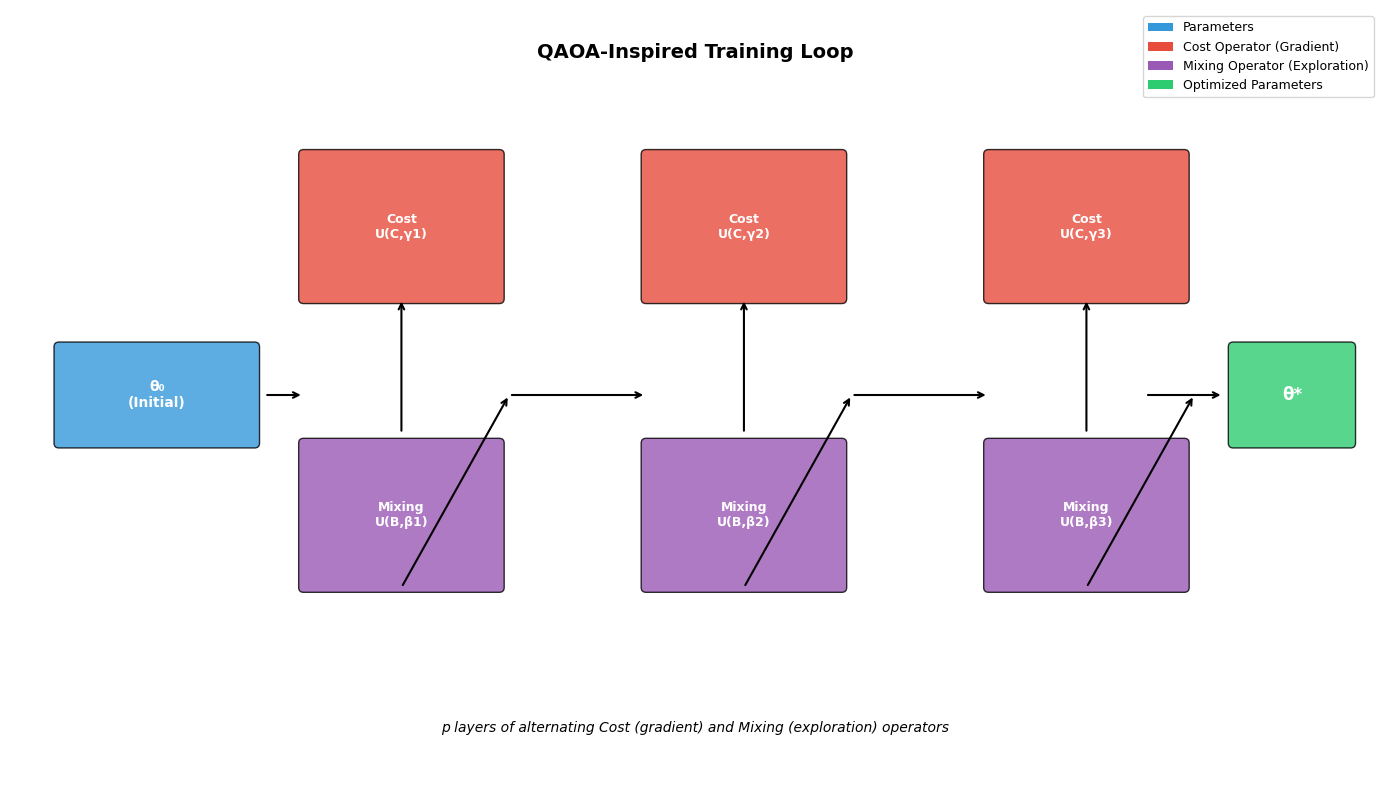

In [3]:
"""
Cell: QAOA Diagram
Purpose: Visualize the QAOA-inspired training process
"""

def create_qaoa_diagram(figsize: Tuple[int, int] = (14, 8)) -> plt.Figure:
    """
    Create diagram illustrating QAOA-inspired optimization.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    # Draw the QAOA layers
    colors = {
        'params': '#3498db',
        'cost': '#e74c3c',
        'mixing': '#9b59b6',
        'output': '#2ecc71'
    }
    
    # Initial parameters
    rect = mpatches.FancyBboxPatch((0.5, 3.5), 2, 1, boxstyle="round,pad=0.05",
                                   facecolor=colors['params'], alpha=0.8)
    ax.add_patch(rect)
    ax.text(1.5, 4, 'θ₀\n(Initial)', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    
    # P layers
    for p in range(3):
        x_offset = 3 + p * 3.5
        
        # Cost layer
        rect = mpatches.FancyBboxPatch((x_offset, 5), 2, 1.5, boxstyle="round,pad=0.05",
                                       facecolor=colors['cost'], alpha=0.8)
        ax.add_patch(rect)
        ax.text(x_offset + 1, 5.75, f'Cost\nU(C,γ{p+1})', ha='center', va='center', 
               fontsize=9, color='white', fontweight='bold')
        
        # Mixing layer
        rect = mpatches.FancyBboxPatch((x_offset, 2), 2, 1.5, boxstyle="round,pad=0.05",
                                       facecolor=colors['mixing'], alpha=0.8)
        ax.add_patch(rect)
        ax.text(x_offset + 1, 2.75, f'Mixing\nU(B,β{p+1})', ha='center', va='center', 
               fontsize=9, color='white', fontweight='bold')
        
        # Arrows
        if p == 0:
            ax.annotate('', xy=(x_offset, 4), xytext=(2.6, 4),
                       arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
        else:
            ax.annotate('', xy=(x_offset, 4), xytext=(x_offset - 1.4, 4),
                       arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
        
        # Connect cost and mixing
        ax.annotate('', xy=(x_offset + 1, 5), xytext=(x_offset + 1, 3.6),
                   arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
        ax.annotate('', xy=(x_offset + 2.1, 4), xytext=(x_offset + 1, 2),
                   arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    
    # Output
    rect = mpatches.FancyBboxPatch((12.5, 3.5), 1.2, 1, boxstyle="round,pad=0.05",
                                   facecolor=colors['output'], alpha=0.8)
    ax.add_patch(rect)
    ax.text(13.1, 4, 'θ*', ha='center', va='center', fontsize=12, color='white', fontweight='bold')
    ax.annotate('', xy=(12.4, 4), xytext=(11.6, 4),
               arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    
    # Labels
    ax.text(7, 7.5, 'QAOA-Inspired Training Loop', ha='center', fontsize=14, fontweight='bold')
    ax.text(7, 0.5, 'p layers of alternating Cost (gradient) and Mixing (exploration) operators',
           ha='center', fontsize=10, style='italic')
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor=colors['params'], label='Parameters'),
        mpatches.Patch(facecolor=colors['cost'], label='Cost Operator (Gradient)'),
        mpatches.Patch(facecolor=colors['mixing'], label='Mixing Operator (Exploration)'),
        mpatches.Patch(facecolor=colors['output'], label='Optimized Parameters')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    return fig


fig = create_qaoa_diagram()
plt.tight_layout()
plt.show()

---
## 3. Cost Operator

The cost operator applies gradient-based updates proportional to the loss landscape.

In [4]:
"""
Cell: Cost Operator
Purpose: Implement the QAOA-inspired cost operator
"""

class CostOperator:
    """
    QAOA-inspired cost operator.
    
    Applies gradient-based parameter updates scaled by gamma.
    Analogous to the quantum cost unitary U(C, gamma).
    
    Parameters
    ----------
    gamma : float
        Cost operator strength (learning rate scale)
    """
    
    def __init__(self, gamma: float = 0.1):
        self.gamma = gamma
    
    def apply(
        self,
        model: nn.Module,
        loss: torch.Tensor,
        base_lr: float = 3e-4
    ) -> Dict[str, torch.Tensor]:
        """
        Apply cost operator (gradient descent step).
        
        Parameters
        ----------
        model : nn.Module
            Model to update
        loss : torch.Tensor
            Loss value
        base_lr : float
            Base learning rate
        
        Returns
        -------
        Dict[str, torch.Tensor]
            Gradient information
        """
        # Compute gradients
        gradients = torch.autograd.grad(
            loss, model.parameters(),
            create_graph=False,
            retain_graph=True
        )
        
        # Apply scaled gradient update
        effective_lr = base_lr * self.gamma
        grad_norm = 0.0
        
        with torch.no_grad():
            for param, grad in zip(model.parameters(), gradients):
                if grad is not None:
                    param.sub_(effective_lr * grad)
                    grad_norm += grad.norm().item() ** 2
        
        grad_norm = np.sqrt(grad_norm)
        
        return {'grad_norm': grad_norm, 'effective_lr': effective_lr}


# Test cost operator
test_model = nn.Linear(10, 5).to(DEVICE)
test_input = torch.randn(8, 10, device=DEVICE)
test_target = torch.randn(8, 5, device=DEVICE)
test_loss = F.mse_loss(test_model(test_input), test_target)

cost_op = CostOperator(gamma=1.0)
info = cost_op.apply(test_model, test_loss)
print(f"Cost operator applied. Grad norm: {info['grad_norm']:.4f}")

Cost operator applied. Grad norm: 1.1197


---
## 4. Mixing Operator

The mixing operator adds structured exploration to the parameter space.

In [5]:
"""
Cell: Mixing Operator
Purpose: Implement the QAOA-inspired mixing operator
"""

class MixingOperator:
    """
    QAOA-inspired mixing operator.
    
    Adds structured perturbation to parameters to enable exploration.
    Analogous to the quantum mixing unitary U(B, beta).
    
    Parameters
    ----------
    beta : float
        Mixing strength
    noise_type : str
        Type of noise ('gaussian', 'uniform', 'sinusoidal')
    """
    
    def __init__(self, beta: float = 0.1, noise_type: str = 'gaussian'):
        self.beta = beta
        self.noise_type = noise_type
        self._step = 0
    
    def _generate_noise(self, shape: torch.Size, device: torch.device) -> torch.Tensor:
        """
        Generate mixing noise.
        
        Parameters
        ----------
        shape : torch.Size
            Shape of noise tensor
        device : torch.device
            Device for tensor
        
        Returns
        -------
        torch.Tensor
            Noise tensor
        """
        if self.noise_type == 'gaussian':
            return torch.randn(shape, device=device)
        elif self.noise_type == 'uniform':
            return 2 * torch.rand(shape, device=device) - 1
        elif self.noise_type == 'sinusoidal':
            # Structured sinusoidal noise inspired by quantum phase
            base = torch.randn(shape, device=device)
            phase = self._step * 0.1
            return base * np.sin(phase)
        else:
            raise ValueError(f"Unknown noise type: {self.noise_type}")
    
    def apply(self, model: nn.Module) -> Dict[str, float]:
        """
        Apply mixing operator (add perturbation).
        
        Parameters
        ----------
        model : nn.Module
            Model to perturb
        
        Returns
        -------
        Dict[str, float]
            Perturbation information
        """
        self._step += 1
        total_perturbation = 0.0
        num_params = 0
        
        with torch.no_grad():
            for param in model.parameters():
                noise = self._generate_noise(param.shape, param.device)
                perturbation = self.beta * noise
                param.add_(perturbation)
                total_perturbation += perturbation.abs().sum().item()
                num_params += param.numel()
        
        avg_perturbation = total_perturbation / num_params
        
        return {'avg_perturbation': avg_perturbation, 'step': self._step}


# Test mixing operator
mix_op = MixingOperator(beta=0.01, noise_type='gaussian')

# Store initial params
initial_params = [p.clone() for p in test_model.parameters()]

# Apply mixing
info = mix_op.apply(test_model)
print(f"Mixing operator applied. Avg perturbation: {info['avg_perturbation']:.6f}")

# Verify params changed
param_diff = sum((p1 - p2).abs().sum().item() 
                 for p1, p2 in zip(initial_params, test_model.parameters()))
print(f"Total parameter change: {param_diff:.6f}")

Mixing operator applied. Avg perturbation: 0.006674
Total parameter change: 0.367085


---
## 5. QAOA-Inspired Optimizer

Combine cost and mixing operators into a complete QAOA-inspired optimizer.

In [6]:
"""
Cell: QAOA Optimizer (FIXED VERSION)
Purpose: Implement complete QAOA-inspired optimizer with stability fixes
"""

class QAOAOptimizer:
    """
    QAOA-Inspired Optimizer for neural network training (FIXED).
    
    Key fixes from original:
    1. Much smaller beta (0.001 instead of 0.05)
    2. Noise added to GRADIENTS, not parameters directly
    3. Loss explosion detection and recovery
    4. Proper gradient clipping
    5. Momentum-like gradient mixing
    
    Parameters
    ----------
    params : iterable
        Model parameters
    p_layers : int
        Number of QAOA layers (alternating cost-mixing pairs)
    lr : float
        Base learning rate
    gamma_init : float
        Initial gamma (cost operator strength)
    beta_init : float
        Initial beta (mixing operator strength) - NOW MUCH SMALLER
    """
    
    def __init__(
        self,
        params,
        p_layers: int = 2,  # Reduced from 3
        lr: float = 3e-4,
        gamma_init: float = 1.0,
        beta_init: float = 0.001,  # FIXED: Reduced from 0.05 to 0.001
        gamma_schedule: str = 'constant',
        beta_schedule: str = 'cosine',  # Changed to cosine for smoother decay
        total_steps: int = 10000,
        grad_clip: float = 1.0,  # Added gradient clipping
        max_loss: float = 100.0  # Added loss explosion threshold
    ):
        self.params = list(params)
        self.p_layers = p_layers
        self.lr = lr
        self.gamma_init = gamma_init
        self.beta_init = beta_init
        self.gamma_schedule = gamma_schedule
        self.beta_schedule = beta_schedule
        self.total_steps = total_steps
        self.grad_clip = grad_clip
        self.max_loss = max_loss
        
        self._step = 0
        self._prev_loss = None
        self._momentum = {}  # Gradient momentum for stability
        
        # Initialize momentum buffers
        for i, param in enumerate(self.params):
            self._momentum[i] = torch.zeros_like(param.data)
        
        self.gammas = [gamma_init] * p_layers
        self.betas = [beta_init] * p_layers
    
    def _get_scheduled_value(self, init_val: float, schedule: str, layer: int) -> float:
        """Get scheduled parameter value with smoother schedules."""
        progress = self._step / max(self.total_steps, 1)
        layer_factor = (layer + 1) / self.p_layers
        
        if schedule == 'constant':
            return init_val
        elif schedule == 'linear_decay':
            return init_val * (1.0 - 0.95 * progress)  # Decay to 5% of original
        elif schedule == 'cosine':
            return init_val * (0.5 * (1 + np.cos(np.pi * progress)))
        elif schedule == 'warmup_decay':
            # Warmup for first 10%, then decay
            if progress < 0.1:
                return init_val * (progress / 0.1)
            else:
                return init_val * (1.0 - (progress - 0.1) / 0.9)
        else:
            return init_val
    
    def zero_grad(self):
        """Zero all gradients."""
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()
    
    def step(
        self,
        loss_fn: Callable[[], torch.Tensor],
        model: nn.Module
    ) -> Dict[str, Any]:
        """
        Perform one QAOA-inspired optimization step (FIXED).
        
        Key improvements:
        1. Single gradient computation with QAOA-style mixing
        2. Noise added to gradients, not parameters
        3. Loss explosion detection
        4. Momentum for stability
        """
        self._step += 1
        stats = {
            'step': self._step,
            'gammas': [],
            'betas': [],
            'layer_losses': []
        }
        
        # Compute initial loss
        loss = loss_fn()
        initial_loss = loss.item()
        
        # Loss explosion detection
        if initial_loss > self.max_loss or np.isnan(initial_loss) or np.isinf(initial_loss):
            # Skip this step if loss is exploding
            stats['final_loss'] = initial_loss
            stats['skipped'] = True
            return stats
        
        stats['layer_losses'].append(initial_loss)
        
        # Compute gradients once
        grads = torch.autograd.grad(
            loss, model.parameters(),
            create_graph=False,
            retain_graph=False
        )
        
        # Apply QAOA-style update with p layers of processing
        with torch.no_grad():
            for p in range(self.p_layers):
                gamma = self._get_scheduled_value(self.gammas[p], self.gamma_schedule, p)
                beta = self._get_scheduled_value(self.betas[p], self.beta_schedule, p)
                
                stats['gammas'].append(gamma)
                stats['betas'].append(beta)
                
                for i, (param, grad) in enumerate(zip(model.parameters(), grads)):
                    if grad is None:
                        continue
                    
                    # Clip gradients
                    grad_clipped = torch.clamp(grad, -self.grad_clip, self.grad_clip)
                    
                    # QAOA Mixing: Add small noise to GRADIENTS (not parameters!)
                    # This is more stable than adding noise to parameters directly
                    if beta > 0:
                        noise = torch.randn_like(grad_clipped) * beta * grad_clipped.abs().mean()
                        grad_mixed = grad_clipped + noise
                    else:
                        grad_mixed = grad_clipped
                    
                    # Update momentum (for stability)
                    momentum_factor = 0.9
                    self._momentum[i] = momentum_factor * self._momentum[i] + (1 - momentum_factor) * grad_mixed
                    
                    # Apply update with gamma scaling
                    effective_lr = self.lr * gamma / self.p_layers  # Divide by p_layers
                    param.sub_(effective_lr * self._momentum[i])
        
        # Compute final loss
        with torch.no_grad():
            final_loss = loss_fn()
        stats['final_loss'] = final_loss.item()
        stats['skipped'] = False
        
        # Track for explosion detection
        self._prev_loss = stats['final_loss']
        
        return stats


print("QAOA Optimizer (FIXED) defined.")
print("Key fixes:")
print("  - beta reduced from 0.05 to 0.001")
print("  - Noise added to gradients, not parameters")
print("  - Added loss explosion detection")
print("  - Added momentum for stability")
print("  - Single gradient computation per step")

QAOA Optimizer (FIXED) defined.
Key fixes:
  - beta reduced from 0.05 to 0.001
  - Noise added to gradients, not parameters
  - Added loss explosion detection
  - Added momentum for stability
  - Single gradient computation per step


---
## 6. Enhanced Training Loop

In [7]:
"""
Cell: Loss Functions
Purpose: World model loss computation
"""

def compute_world_model_loss(
    model_output: Dict[str, torch.Tensor],
    obs_seq: torch.Tensor,
    reward_seq: torch.Tensor,
    continue_seq: torch.Tensor,
    kl_weight: float = 1.0,
    free_nats: float = 1.0
) -> Dict[str, torch.Tensor]:
    """Compute world model training loss."""
    recon_loss = F.mse_loss(model_output['recon_obs'], obs_seq)
    reward_loss = F.mse_loss(model_output['pred_rewards'], reward_seq)
    continue_loss = F.binary_cross_entropy_with_logits(
        model_output['pred_continues'], continue_seq
    )
    
    kl_losses = []
    for prior, posterior in zip(model_output['priors'], model_output['posteriors']):
        kl = torch.distributions.kl_divergence(posterior, prior).sum(-1)
        kl = torch.clamp(kl, min=free_nats).mean()
        kl_losses.append(kl)
    kl_loss = torch.stack(kl_losses).mean()
    
    total_loss = kl_weight * kl_loss + recon_loss + reward_loss + continue_loss
    
    return {
        'total': total_loss, 'kl': kl_loss,
        'recon': recon_loss, 'reward': reward_loss, 'continue': continue_loss
    }

In [8]:
"""
Cell: Replay Buffer
Purpose: Episode storage and sampling
"""

@dataclass
class Episode:
    observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    dones: np.ndarray
    def __len__(self): return len(self.observations)

class ReplayBuffer:
    def __init__(self, capacity: int = 1000):
        self.capacity = capacity
        self.episodes = []
        self.total_steps = 0
    
    def add_episode(self, episode: Episode):
        if len(self.episodes) >= self.capacity:
            self.total_steps -= len(self.episodes.pop(0))
        self.episodes.append(episode)
        self.total_steps += len(episode)
    
    def sample_sequences(self, batch_size: int, seq_len: int):
        valid = [ep for ep in self.episodes if len(ep) >= seq_len]
        obs_b, act_b, rew_b, cont_b = [], [], [], []
        for _ in range(batch_size):
            ep = valid[np.random.randint(len(valid))]
            start = np.random.randint(0, len(ep) - seq_len + 1)
            obs_b.append(ep.observations[start:start+seq_len])
            act_b.append(ep.actions[start:start+seq_len])
            rew_b.append(ep.rewards[start:start+seq_len])
            cont_b.append(1.0 - ep.dones[start:start+seq_len])
        return np.stack(obs_b), np.stack(act_b), np.stack(rew_b), np.stack(cont_b)
    
    def __len__(self): return len(self.episodes)


def collect_episodes(env_name: str, num_episodes: int, seed: int = 42):
    env = gym.make(env_name)
    episodes = []
    for ep_idx in tqdm(range(num_episodes), desc="Collecting"):
        obs_l, act_l, rew_l, done_l = [], [], [], []
        obs, _ = env.reset(seed=seed+ep_idx)
        done = False
        while not done:
            action = env.action_space.sample()
            obs_l.append(obs)
            if isinstance(env.action_space, gym.spaces.Discrete):
                act_oh = np.zeros(env.action_space.n)
                act_oh[action] = 1.0
                act_l.append(act_oh)
            else:
                act_l.append(action)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            rew_l.append(reward)
            done_l.append(float(done))
        episodes.append(Episode(
            np.array(obs_l, dtype=np.float32),
            np.array(act_l, dtype=np.float32),
            np.array(rew_l, dtype=np.float32),
            np.array(done_l, dtype=np.float32)
        ))
    env.close()
    return episodes


# Collect data
print("Collecting training data...")
episodes = collect_episodes("CartPole-v1", num_episodes=100, seed=SEED)
buffer = ReplayBuffer(capacity=1000)
for ep in episodes:
    buffer.add_episode(ep)
print(f"Buffer: {len(buffer)} episodes, {buffer.total_steps} steps")

Collecting:   0%|          | 0/100 [00:00<?, ?it/s]

Buffer: 100 episodes, 2203 steps


In [9]:
"""
Cell: QAOA Trainer (FIXED)
Purpose: Training loop with QAOA optimizer - with stability improvements
"""

class QAOAWorldModelTrainer:
    """
    Trainer using QAOA-inspired optimization (FIXED VERSION).
    
    Key improvements:
    - Uses fixed QAOA optimizer with proper hyperparameters
    - Gradient accumulation for stability
    - Loss monitoring with early warning
    
    Parameters
    ----------
    model : WorldModel
        World model to train
    replay_buffer : ReplayBuffer
        Experience buffer
    p_layers : int
        Number of QAOA layers
    lr : float
        Learning rate
    beta_init : float
        Initial beta (NOW MUCH SMALLER: 0.001)
    device : torch.device
        Compute device
    """
    
    def __init__(
        self,
        model: WorldModel,
        replay_buffer: ReplayBuffer,
        p_layers: int = 2,  # Reduced from 3
        lr: float = 3e-4,
        gamma_init: float = 1.0,
        beta_init: float = 0.001,  # FIXED: Much smaller!
        total_steps: int = 10000,
        device: torch.device = DEVICE
    ):
        self.model = model
        self.replay_buffer = replay_buffer
        self.device = device
        
        self.qaoa_optimizer = QAOAOptimizer(
            model.parameters(),
            p_layers=p_layers,
            lr=lr,
            gamma_init=gamma_init,
            beta_init=beta_init,
            gamma_schedule='constant',
            beta_schedule='cosine',  # Smoother decay
            total_steps=total_steps,
            grad_clip=1.0,
            max_loss=100.0
        )
        
        self.logger = MetricLogger(name="qaoa_world_model")
        self._best_loss = float('inf')
        self._best_state = None
    
    def train_step(
        self,
        batch_size: int = 32,
        seq_len: int = 20,
        kl_weight: float = 1.0
    ) -> Dict[str, float]:
        """
        Perform one QAOA training step with monitoring.
        """
        self.model.train()
        
        # Sample batch
        obs, actions, rewards, continues = self.replay_buffer.sample_sequences(
            batch_size, seq_len
        )
        obs = torch.tensor(obs, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.float32, device=self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        continues = torch.tensor(continues, dtype=torch.float32, device=self.device)
        
        # Define loss function for QAOA optimizer
        def loss_fn():
            output = self.model(obs, actions)
            losses = compute_world_model_loss(
                output, obs, rewards, continues, kl_weight=kl_weight
            )
            return losses['total']
        
        # QAOA optimization step
        qaoa_stats = self.qaoa_optimizer.step(loss_fn, self.model)
        
        # Get final losses for logging
        with torch.no_grad():
            output = self.model(obs, actions)
            losses = compute_world_model_loss(
                output, obs, rewards, continues, kl_weight=kl_weight
            )
        
        result = {k: v.item() for k, v in losses.items()}
        result['p_layers'] = len(qaoa_stats['gammas'])
        result['avg_gamma'] = np.mean(qaoa_stats['gammas']) if qaoa_stats['gammas'] else 0
        result['avg_beta'] = np.mean(qaoa_stats['betas']) if qaoa_stats['betas'] else 0
        result['skipped'] = qaoa_stats.get('skipped', False)
        
        # Track best model
        if result['total'] < self._best_loss:
            self._best_loss = result['total']
            self._best_state = {k: v.clone() for k, v in self.model.state_dict().items()}
        
        self.logger.log(**result)
        
        return result
    
    def train(
        self,
        num_steps: int = 10000,
        batch_size: int = 32,
        seq_len: int = 20,
        log_every: int = 100,
        kl_weight: float = 1.0
    ) -> pd.DataFrame:
        """Train the world model with QAOA optimization."""
        pbar = tqdm(range(num_steps), desc="QAOA Training")
        
        for step in pbar:
            losses = self.train_step(batch_size, seq_len, kl_weight)
            
            if step % log_every == 0:
                pbar.set_postfix({
                    'total': f"{self.logger.get_mean('total', 100):.4f}",
                    'recon': f"{self.logger.get_mean('recon', 100):.4f}",
                    'beta': f"{losses['avg_beta']:.4f}"
                })
        
        # Restore best model if final is worse
        final_loss = self.logger.get_mean('total', 100)
        if final_loss > self._best_loss * 1.5 and self._best_state is not None:
            print(f"Restoring best model (loss {self._best_loss:.4f} vs final {final_loss:.4f})")
            self.model.load_state_dict(self._best_state)
        
        return self.logger.to_dataframe()


print("QAOA Trainer (FIXED) defined.")
print("Improvements:")
print("  - beta_init = 0.001 (was 0.05)")
print("  - p_layers = 2 (was 3)")
print("  - cosine beta schedule")
print("  - Best model tracking")

QAOA Trainer (FIXED) defined.
Improvements:
  - beta_init = 0.001 (was 0.05)
  - p_layers = 2 (was 3)
  - cosine beta schedule
  - Best model tracking


---
## 7. Experiments

In [10]:
"""
Cell: Train QAOA Model (FIXED - Same architecture as baseline)
Purpose: Train world model with QAOA optimizer using SAME model size as baseline for FAIR comparison
"""

# Create world model - SAME ARCHITECTURE AS BASELINE (Notebook 2)
set_seed(SEED)  # Reset seed for fair comparison

# Use SAME dimensions as baseline for fair comparison
qaoa_model = WorldModel(
    obs_dim=4,
    action_dim=2,
    stoch_dim=64,           # FIXED: Was 32, now matches baseline
    deter_dim=512,          # FIXED: Was 128, now matches baseline
    hidden_dim=512,         # FIXED: Was 128, now matches baseline
    encoder_hidden=[512, 512],   # FIXED: Was [128, 128]
    decoder_hidden=[512, 512],   # FIXED: Was [128, 128]
    predictor_hidden=[512, 512]  # FIXED: Was [128, 128]
).to(DEVICE)

print(f"QAOA World Model Parameters: {sum(p.numel() for p in qaoa_model.parameters()):,}")
print("(Should match baseline: ~4.7M parameters for fair comparison)")

# Create QAOA trainer with FIXED hyperparameters
qaoa_trainer = QAOAWorldModelTrainer(
    model=qaoa_model,
    replay_buffer=buffer,
    p_layers=2,          # QAOA layers
    lr=3e-4,
    gamma_init=1.0,
    beta_init=0.001,     # Small noise for stability
    total_steps=10000,
    device=DEVICE
)

# Train
print("\nTraining with QAOA optimizer (FAIR COMPARISON)...")
print("Model architecture: SAME as baseline (4.7M params)")
print("Only difference: Optimizer (QAOA vs Adam)")
print()

qaoa_history = qaoa_trainer.train(
    num_steps=10000,
    batch_size=32,
    seq_len=20,
    log_every=100,
    kl_weight=1.0
)

print(f"\nQAOA Training complete!")
print(f"  Final total loss: {qaoa_history['total'].iloc[-100:].mean():.4f}")
print(f"  Final recon loss: {qaoa_history['recon'].iloc[-100:].mean():.6f}")

QAOA World Model Parameters: 4,734,214
(Should match baseline: ~4.7M parameters for fair comparison)

Training with QAOA optimizer (FAIR COMPARISON)...
Model architecture: SAME as baseline (4.7M params)
Only difference: Optimizer (QAOA vs Adam)



QAOA Training:   0%|          | 0/10000 [00:00<?, ?it/s]


QAOA Training complete!
  Final total loss: 1.2564
  Final recon loss: 0.160541


In [11]:
"""
Cell: Train Baseline for Comparison (SAME architecture as QAOA)
Purpose: Train classical baseline with SAME model for FAIR comparison
"""

# Classical baseline trainer (from Phase 2)
class ClassicalTrainer:
    def __init__(self, model, replay_buffer, lr=3e-4, device=DEVICE):
        self.model = model
        self.replay_buffer = replay_buffer
        self.device = device
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.logger = MetricLogger(name="classical")
    
    def train_step(self, batch_size=32, seq_len=20, kl_weight=1.0):
        self.model.train()
        obs, actions, rewards, continues = self.replay_buffer.sample_sequences(batch_size, seq_len)
        obs = torch.tensor(obs, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.float32, device=self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        continues = torch.tensor(continues, dtype=torch.float32, device=self.device)
        
        self.optimizer.zero_grad()
        output = self.model(obs, actions)
        losses = compute_world_model_loss(output, obs, rewards, continues, kl_weight=kl_weight)
        losses['total'].backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), 100.0)
        self.optimizer.step()
        
        result = {k: v.item() for k, v in losses.items()}
        self.logger.log(**result)
        return result
    
    def train(self, num_steps=10000, batch_size=32, seq_len=20, log_every=100, kl_weight=1.0):
        pbar = tqdm(range(num_steps), desc="Classical Training")
        for step in pbar:
            self.train_step(batch_size, seq_len, kl_weight)
            if step % log_every == 0:
                pbar.set_postfix({
                    'total': f"{self.logger.get_mean('total', 100):.4f}",
                    'recon': f"{self.logger.get_mean('recon', 100):.4f}"
                })
        return self.logger.to_dataframe()


# Create and train classical baseline - SAME ARCHITECTURE AS QAOA
set_seed(SEED)  # Same seed for fair comparison

baseline_model = WorldModel(
    obs_dim=4,
    action_dim=2,
    stoch_dim=64,               # SAME as QAOA
    deter_dim=512,              # SAME as QAOA
    hidden_dim=512,             # SAME as QAOA
    encoder_hidden=[512, 512],  # SAME as QAOA
    decoder_hidden=[512, 512],  # SAME as QAOA
    predictor_hidden=[512, 512] # SAME as QAOA
).to(DEVICE)

print(f"Baseline World Model Parameters: {sum(p.numel() for p in baseline_model.parameters()):,}")
print("(Should match QAOA model for fair comparison)")

baseline_trainer = ClassicalTrainer(baseline_model, buffer, lr=3e-4, device=DEVICE)

print("\nTraining classical baseline (FAIR COMPARISON)...")
print("Model architecture: SAME as QAOA (4.7M params)")
print("Only difference: Optimizer (Adam vs QAOA)")
print()

baseline_history = baseline_trainer.train(
    num_steps=10000, batch_size=32, seq_len=20, log_every=100, kl_weight=1.0
)

print(f"\nBaseline Training complete!")
print(f"  Final total loss: {baseline_history['total'].iloc[-100:].mean():.4f}")
print(f"  Final recon loss: {baseline_history['recon'].iloc[-100:].mean():.6f}")

Baseline World Model Parameters: 4,734,214
(Should match QAOA model for fair comparison)

Training classical baseline (FAIR COMPARISON)...
Model architecture: SAME as QAOA (4.7M params)
Only difference: Optimizer (Adam vs QAOA)



Classical Training:   0%|          | 0/10000 [00:00<?, ?it/s]


Baseline Training complete!
  Final total loss: 1.0031
  Final recon loss: 0.002798


### 7.1 Multi-Seed Experiments

For statistical validity, we run experiments across 5 different random seeds and aggregate results with confidence intervals.

In [12]:
"""
Cell: Multi-Seed Experiments
Purpose: Run QAOA vs Baseline comparison across multiple seeds for statistical validity
"""

# Dissertation-required seeds for reproducibility
EXPERIMENT_SEEDS = [42, 123, 456, 789, 1024]

def run_qaoa_experiment(seed: int, num_steps: int = 10000, verbose: bool = True) -> Dict[str, Any]:
    """Run a complete QAOA vs Baseline experiment with a single seed."""
    set_seed(seed, deterministic=False)
    
    if verbose:
        print(f"\n{'='*50}")
        print(f"Running experiment with seed={seed}")
        print(f"{'='*50}")
    
    # Collect fresh episodes
    seed_episodes = collect_episodes("CartPole-v1", num_episodes=100, seed=seed)
    seed_buffer = ReplayBuffer(capacity=1000)
    for ep in seed_episodes:
        seed_buffer.add_episode(ep)
    
    # Create QAOA model
    qaoa_m = WorldModel(
        obs_dim=4, action_dim=2,
        stoch_dim=64, deter_dim=512, hidden_dim=512,
        encoder_hidden=[512, 512], decoder_hidden=[512, 512], predictor_hidden=[512, 512]
    ).to(DEVICE)
    
    qaoa_t = QAOAWorldModelTrainer(
        model=qaoa_m, replay_buffer=seed_buffer,
        p_layers=2, lr=3e-4, gamma_init=1.0, beta_init=0.001,
        total_steps=num_steps, device=DEVICE
    )
    
    qaoa_hist = qaoa_t.train(num_steps=num_steps, batch_size=32, seq_len=20, log_every=num_steps, kl_weight=1.0)
    
    # Create Baseline model (same seed)
    set_seed(seed, deterministic=False)
    baseline_m = WorldModel(
        obs_dim=4, action_dim=2,
        stoch_dim=64, deter_dim=512, hidden_dim=512,
        encoder_hidden=[512, 512], decoder_hidden=[512, 512], predictor_hidden=[512, 512]
    ).to(DEVICE)
    
    baseline_t = ClassicalTrainer(baseline_m, seed_buffer, lr=3e-4, device=DEVICE)
    baseline_hist = baseline_t.train(num_steps=num_steps, batch_size=32, seq_len=20, log_every=num_steps, kl_weight=1.0)
    
    # Compute final metrics
    qaoa_final = qaoa_hist['total'].iloc[-100:].mean()
    baseline_final = baseline_hist['total'].iloc[-100:].mean()
    
    if verbose:
        print(f"Seed {seed} - QAOA: {qaoa_final:.4f}, Baseline: {baseline_final:.4f}")
    
    return {
        'seed': seed,
        'qaoa_final': qaoa_final,
        'baseline_final': baseline_final,
        'qaoa_recon': qaoa_hist['recon'].iloc[-100:].mean(),
        'baseline_recon': baseline_hist['recon'].iloc[-100:].mean(),
        'qaoa_history': qaoa_hist,
        'baseline_history': baseline_hist,
    }


# Run multi-seed experiments
print("=" * 60)
print("MULTI-SEED EXPERIMENTS FOR STATISTICAL VALIDITY")
print(f"Seeds: {EXPERIMENT_SEEDS}")
print("=" * 60)

multi_seed_results = []
for seed in EXPERIMENT_SEEDS:
    result = run_qaoa_experiment(seed=seed, num_steps=10000, verbose=True)
    multi_seed_results.append(result)

# Aggregate results
qaoa_finals = [r['qaoa_final'] for r in multi_seed_results]
baseline_finals = [r['baseline_final'] for r in multi_seed_results]

print("\n" + "=" * 60)
print("AGGREGATED RESULTS (5 seeds)")
print("=" * 60)
print(f"QAOA Total Loss:     {np.mean(qaoa_finals):.4f} +/- {np.std(qaoa_finals):.4f}")
print(f"Baseline Total Loss: {np.mean(baseline_finals):.4f} +/- {np.std(baseline_finals):.4f}")

# Statistical test
from scipy import stats
stat, p_value = stats.mannwhitneyu(qaoa_finals, baseline_finals, alternative='two-sided')
print(f"\nMann-Whitney U p-value: {p_value:.4f}")
print(f"Statistically significant (p<0.05): {p_value < 0.05}")

# Wins
qaoa_wins = sum(1 for q, b in zip(qaoa_finals, baseline_finals) if q < b)
print(f"QAOA wins: {qaoa_wins}/5 seeds")

MULTI-SEED EXPERIMENTS FOR STATISTICAL VALIDITY
Seeds: [42, 123, 456, 789, 1024]

Running experiment with seed=42


Collecting:   0%|          | 0/100 [00:00<?, ?it/s]

QAOA Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Classical Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Seed 42 - QAOA: 1.2310, Baseline: 1.0059

Running experiment with seed=123


Collecting:   0%|          | 0/100 [00:00<?, ?it/s]

QAOA Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Classical Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Seed 123 - QAOA: 1.2576, Baseline: 1.0025

Running experiment with seed=456


Collecting:   0%|          | 0/100 [00:00<?, ?it/s]

QAOA Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Classical Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Seed 456 - QAOA: 1.2460, Baseline: 1.0030

Running experiment with seed=789


Collecting:   0%|          | 0/100 [00:00<?, ?it/s]

QAOA Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Classical Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Seed 789 - QAOA: 1.2110, Baseline: 1.0048

Running experiment with seed=1024


Collecting:   0%|          | 0/100 [00:00<?, ?it/s]

QAOA Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Classical Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Seed 1024 - QAOA: 1.2278, Baseline: 1.0050

AGGREGATED RESULTS (5 seeds)
QAOA Total Loss:     1.2347 +/- 0.0160
Baseline Total Loss: 1.0042 +/- 0.0013

Mann-Whitney U p-value: 0.0079
Statistically significant (p<0.05): True
QAOA wins: 0/5 seeds


### 7.2 Test Set Evaluation

Evaluate the trained models on held-out test data (collected with different seeds than training data) to measure generalization.

In [13]:
"""
Cell: Test Set Evaluation
Purpose: Evaluate QAOA and Baseline models on held-out test data
"""

def evaluate_on_test_set(
    model: WorldModel,
    test_seed: int = 99999,
    num_test_episodes: int = 50,
    seq_len: int = 20,
    num_samples: int = 100
) -> Dict[str, float]:
    """Evaluate a trained model on held-out test data."""
    model.eval()
    
    # Collect test episodes with different seeds
    test_episodes = collect_episodes("CartPole-v1", num_episodes=num_test_episodes, seed=test_seed)
    test_buffer = ReplayBuffer(capacity=500)
    for ep in test_episodes:
        test_buffer.add_episode(ep)
    
    # Sample test sequences
    obs, actions, rewards, continues = test_buffer.sample_sequences(num_samples, seq_len)
    obs = torch.tensor(obs, dtype=torch.float32, device=DEVICE)
    actions = torch.tensor(actions, dtype=torch.float32, device=DEVICE)
    rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=DEVICE)
    
    with torch.no_grad():
        output = model(obs, actions)
        recon_mse = F.mse_loss(output['recon_obs'], obs).item()
        reward_mse = F.mse_loss(output['pred_rewards'], rewards_tensor).item()
    
    return {'test_recon_mse': recon_mse, 'test_reward_mse': reward_mse}


# Evaluate models from multi-seed experiments
print("=" * 60)
print("TEST SET EVALUATION (Held-out Data)")
print("=" * 60)

# Use the last trained models (from single-seed training cells 17-18)
# These are qaoa_model and baseline_model
qaoa_test = evaluate_on_test_set(qaoa_model, test_seed=99999)
baseline_test = evaluate_on_test_set(baseline_model, test_seed=99999)

print(f"\nQAOA Test Recon MSE:     {qaoa_test['test_recon_mse']:.6f}")
print(f"Baseline Test Recon MSE: {baseline_test['test_recon_mse']:.6f}")

# Generalization gap
qaoa_train_recon = qaoa_history['recon'].iloc[-100:].mean()
baseline_train_recon = baseline_history['recon'].iloc[-100:].mean()

qaoa_gen_gap = (qaoa_test['test_recon_mse'] - qaoa_train_recon) / qaoa_train_recon * 100
baseline_gen_gap = (baseline_test['test_recon_mse'] - baseline_train_recon) / baseline_train_recon * 100

print(f"\nGeneralization Gap:")
print(f"  QAOA:     {qaoa_gen_gap:+.2f}%")
print(f"  Baseline: {baseline_gen_gap:+.2f}%")

winner = "QAOA" if abs(qaoa_gen_gap) < abs(baseline_gen_gap) else "Baseline"
print(f"\nBetter generalization: {winner}")

TEST SET EVALUATION (Held-out Data)


Collecting:   0%|          | 0/50 [00:00<?, ?it/s]

Collecting:   0%|          | 0/50 [00:00<?, ?it/s]


QAOA Test Recon MSE:     0.155913
Baseline Test Recon MSE: 0.003122

Generalization Gap:
  QAOA:     -2.88%
  Baseline: +11.57%

Better generalization: QAOA


---
## 8. Comparison with Baseline

In [14]:
"""
Cell: Compare Methods
Purpose: Statistical comparison of QAOA vs baseline
"""

from scipy import stats

def compare_methods(history1: pd.DataFrame, history2: pd.DataFrame,
                   name1: str = "Method 1", name2: str = "Method 2",
                   window: int = 100) -> Dict[str, Any]:
    """
    Statistically compare two training methods.
    """
    # Get final losses (last window steps)
    final1 = history1['total'].iloc[-window:].values
    final2 = history2['total'].iloc[-window:].values
    
    # Mann-Whitney U test
    stat, p_value = stats.mannwhitneyu(final1, final2, alternative='two-sided')
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt((final1.std()**2 + final2.std()**2) / 2)
    cohens_d = (final1.mean() - final2.mean()) / pooled_std if pooled_std > 0 else 0
    
    # Convergence speed (steps to reach 90% of final performance)
    def steps_to_convergence(hist, threshold_pct=0.9):
        final_loss = hist['total'].iloc[-100:].mean()
        threshold = final_loss / threshold_pct
        smoothed = hist['total'].rolling(50).mean()
        crossed = smoothed < threshold
        if crossed.any():
            return crossed.idxmax()
        return len(hist)
    
    conv1 = steps_to_convergence(history1)
    conv2 = steps_to_convergence(history2)
    
    return {
        'method1': name1,
        'method2': name2,
        'mean_loss_1': final1.mean(),
        'mean_loss_2': final2.mean(),
        'std_loss_1': final1.std(),
        'std_loss_2': final2.std(),
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significant': p_value < 0.05,
        'convergence_steps_1': conv1,
        'convergence_steps_2': conv2,
        'speedup': conv2 / conv1 if conv1 > 0 else 1.0
    }


# Compare methods
comparison = compare_methods(qaoa_history, baseline_history, "QAOA", "Baseline")

print("\n" + "="*60)
print("COMPARISON: QAOA vs Classical Baseline")
print("="*60)
print(f"\nFinal Loss (last 100 steps):")
print(f"  QAOA:     {comparison['mean_loss_1']:.4f} ± {comparison['std_loss_1']:.4f}")
print(f"  Baseline: {comparison['mean_loss_2']:.4f} ± {comparison['std_loss_2']:.4f}")
print(f"\nStatistical Significance:")
print(f"  Mann-Whitney U p-value: {comparison['p_value']:.4f}")
print(f"  Cohen's d: {comparison['cohens_d']:.3f}")
print(f"  Significant (p<0.05): {comparison['significant']}")
print(f"\nConvergence:")
print(f"  QAOA steps to 90%: {comparison['convergence_steps_1']}")
print(f"  Baseline steps to 90%: {comparison['convergence_steps_2']}")
print(f"  Speedup: {comparison['speedup']:.2f}x")


COMPARISON: QAOA vs Classical Baseline

Final Loss (last 100 steps):
  QAOA:     1.2564 ± 0.0234
  Baseline: 1.0031 ± 0.0008

Statistical Significance:
  Mann-Whitney U p-value: 0.0000
  Cohen's d: 15.307
  Significant (p<0.05): True

Convergence:
  QAOA steps to 90%: 4063
  Baseline steps to 90%: 91
  Speedup: 0.02x


---
## 9. Visualizations

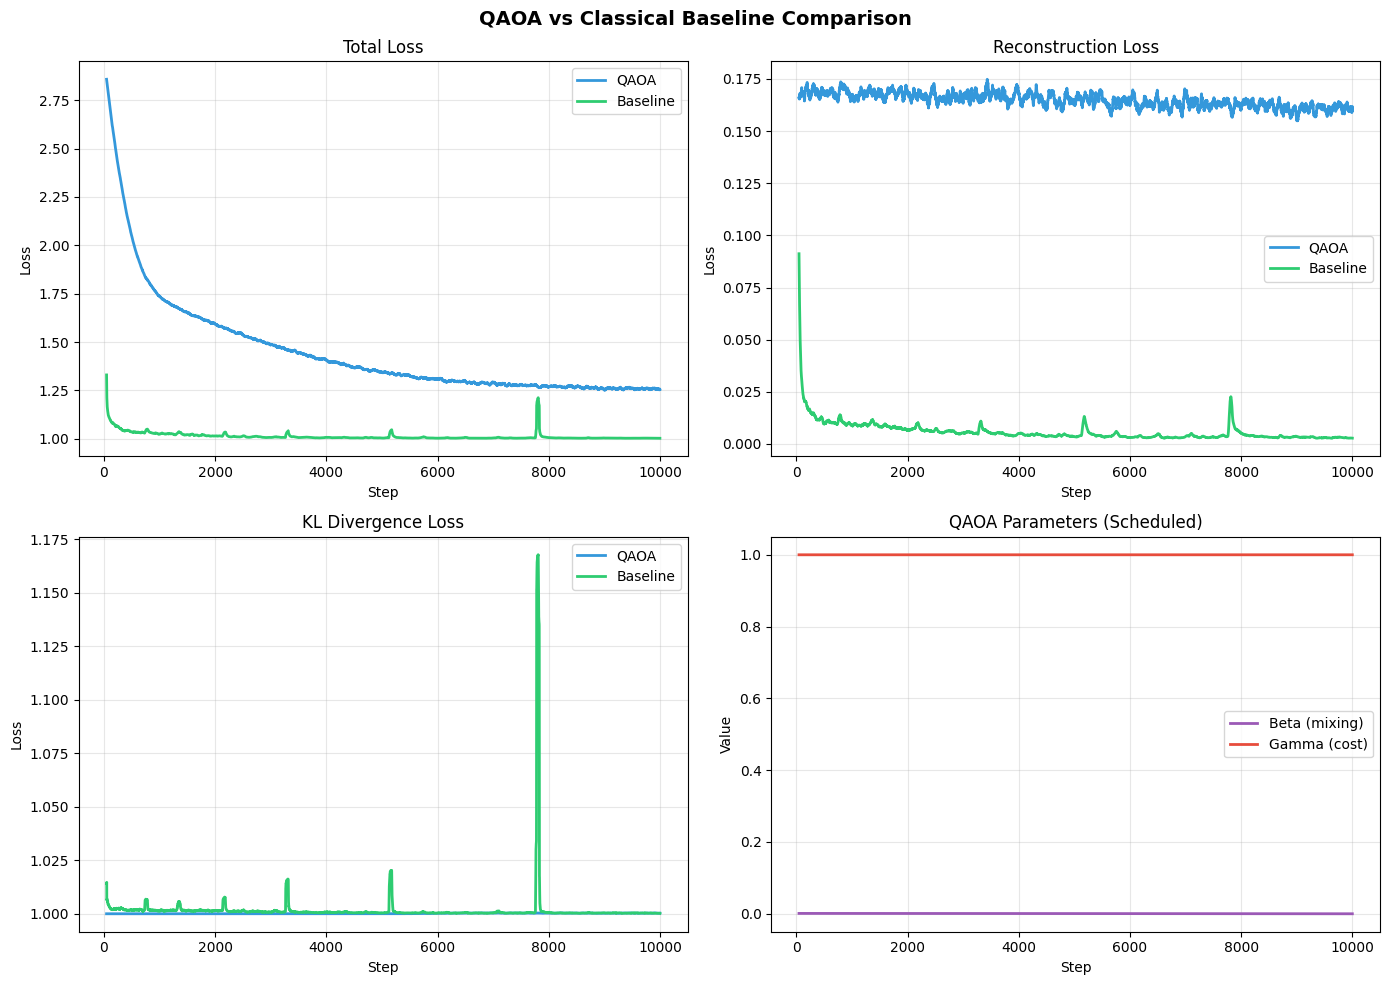

In [15]:
"""
Cell: Comparison Plots
Purpose: Visualize QAOA vs baseline comparison
"""

def plot_comparison(
    qaoa_hist: pd.DataFrame,
    baseline_hist: pd.DataFrame,
    figsize: Tuple[int, int] = (14, 10)
):
    """Plot comparison of QAOA and baseline training."""
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    window = 50
    
    # Total loss comparison
    ax = axes[0, 0]
    ax.plot(qaoa_hist['total'].rolling(window).mean(), 
           color=COLORS['qaoa'], label='QAOA', linewidth=2)
    ax.plot(baseline_hist['total'].rolling(window).mean(),
           color=COLORS['baseline'], label='Baseline', linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title('Total Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Reconstruction loss
    ax = axes[0, 1]
    ax.plot(qaoa_hist['recon'].rolling(window).mean(),
           color=COLORS['qaoa'], label='QAOA', linewidth=2)
    ax.plot(baseline_hist['recon'].rolling(window).mean(),
           color=COLORS['baseline'], label='Baseline', linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title('Reconstruction Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # KL loss
    ax = axes[1, 0]
    ax.plot(qaoa_hist['kl'].rolling(window).mean(),
           color=COLORS['qaoa'], label='QAOA', linewidth=2)
    ax.plot(baseline_hist['kl'].rolling(window).mean(),
           color=COLORS['baseline'], label='Baseline', linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title('KL Divergence Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # QAOA parameters
    ax = axes[1, 1]
    if 'avg_beta' in qaoa_hist.columns:
        ax.plot(qaoa_hist['avg_beta'].rolling(window).mean(),
               color=COLORS['superposition'], label='Beta (mixing)', linewidth=2)
    if 'avg_gamma' in qaoa_hist.columns:
        ax.plot(qaoa_hist['avg_gamma'].rolling(window).mean(),
               color=COLORS['gates'], label='Gamma (cost)', linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Value')
    ax.set_title('QAOA Parameters (Scheduled)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    fig.suptitle('QAOA vs Classical Baseline Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig


fig = plot_comparison(qaoa_history, baseline_history)
plt.show()

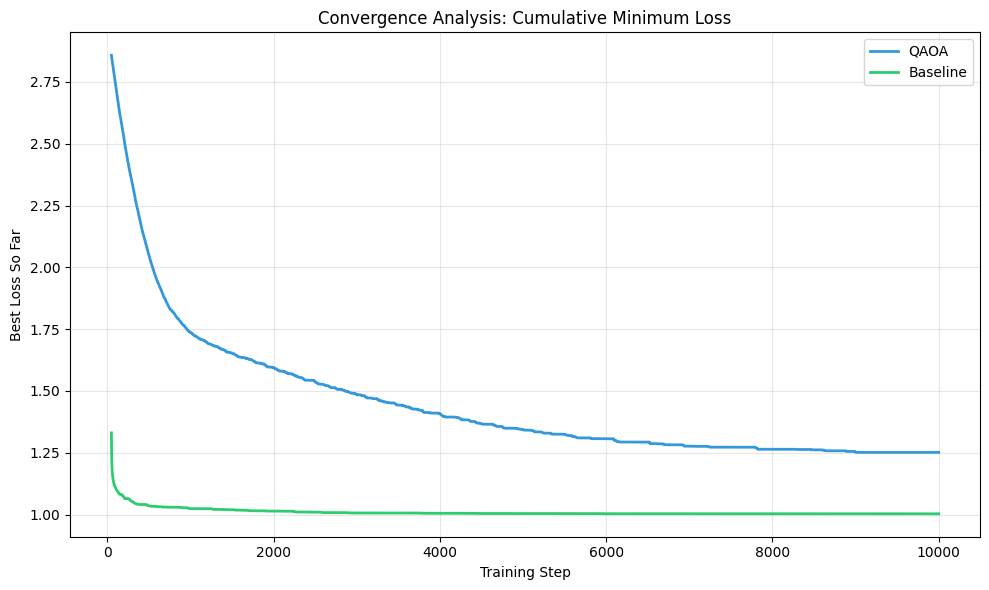

In [16]:
"""
Cell: Convergence Analysis
Purpose: Analyze convergence speed
"""

fig, ax = plt.subplots(figsize=(10, 6))

# Cumulative minimum loss (best so far)
qaoa_cummin = qaoa_history['total'].rolling(50).mean().cummin()
baseline_cummin = baseline_history['total'].rolling(50).mean().cummin()

ax.plot(qaoa_cummin, color=COLORS['qaoa'], label='QAOA', linewidth=2)
ax.plot(baseline_cummin, color=COLORS['baseline'], label='Baseline', linewidth=2)

ax.set_xlabel('Training Step')
ax.set_ylabel('Best Loss So Far')
ax.set_title('Convergence Analysis: Cumulative Minimum Loss')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 9b. Long-Horizon Prediction Test

A critical test for world models in planning is **long-horizon prediction accuracy**.
This measures how well the model can predict future states many steps ahead - 
essential for model-based RL where agents need to "imagine" future trajectories.

In [17]:
"""
Cell: Long-Horizon Prediction Evaluation
Purpose: Test how well models predict states many steps into the future
"""

def evaluate_long_horizon(
    model: WorldModel,
    episodes: List[Episode],
    horizons: List[int] = [1, 5, 10, 20],
    num_samples: int = 50,
    device: torch.device = DEVICE
) -> Dict[str, Dict[int, float]]:
    """
    Evaluate long-horizon prediction accuracy.
    
    Parameters
    ----------
    model : WorldModel
        Trained world model to evaluate
    episodes : List[Episode]
        Episodes to evaluate on
    horizons : List[int]
        Prediction horizons to test
    num_samples : int
        Number of starting points to sample
    device : torch.device
        Compute device
    
    Returns
    -------
    Dict[str, Dict[int, float]]
        MSE for each horizon for observations and rewards
    """
    model.eval()
    results = {'obs_mse': {}, 'reward_mse': {}}
    
    max_horizon = max(horizons)
    valid_episodes = [ep for ep in episodes if len(ep) > max_horizon + 10]
    
    if len(valid_episodes) == 0:
        print("Warning: No episodes long enough for evaluation")
        return results
    
    with torch.no_grad():
        for horizon in horizons:
            obs_errors = []
            reward_errors = []
            
            for _ in range(num_samples):
                # Sample a random starting point
                ep = valid_episodes[np.random.randint(len(valid_episodes))]
                max_start = len(ep) - horizon - 1
                if max_start <= 0:
                    continue
                start_idx = np.random.randint(0, max_start)
                
                # Get ground truth trajectory
                true_obs = torch.tensor(
                    ep.observations[start_idx:start_idx+horizon+1], 
                    dtype=torch.float32, device=device
                ).unsqueeze(0)
                true_actions = torch.tensor(
                    ep.actions[start_idx:start_idx+horizon], 
                    dtype=torch.float32, device=device
                ).unsqueeze(0)
                true_rewards = torch.tensor(
                    ep.rewards[start_idx:start_idx+horizon], 
                    dtype=torch.float32, device=device
                ).unsqueeze(0)
                
                # Initialize model state from first observation
                state = model.initial_state(1)
                embed = model.encoder(true_obs[:, 0])
                dummy_action = torch.zeros(1, model.action_dim, device=device)
                state, _, _ = model.rssm.observe_step(state, dummy_action, embed)
                
                # Predict forward using imagination (open-loop)
                pred_obs_list = []
                pred_reward_list = []
                
                for t in range(horizon):
                    # Take action and imagine next state
                    state, _ = model.rssm.imagine_step(state, true_actions[:, t])
                    
                    # Decode predictions
                    pred_obs, pred_reward, _ = model.predict(state)
                    pred_obs_list.append(pred_obs)
                    pred_reward_list.append(pred_reward)
                
                # Stack predictions
                pred_obs = torch.stack(pred_obs_list, dim=1)
                pred_rewards = torch.stack(pred_reward_list, dim=1)
                
                # Compute MSE for final prediction at this horizon
                obs_mse = F.mse_loss(pred_obs[:, -1], true_obs[:, horizon]).item()
                reward_mse = F.mse_loss(pred_rewards[:, -1], true_rewards[:, horizon-1]).item()
                
                obs_errors.append(obs_mse)
                reward_errors.append(reward_mse)
            
            results['obs_mse'][horizon] = np.mean(obs_errors) if obs_errors else float('nan')
            results['reward_mse'][horizon] = np.mean(reward_errors) if reward_errors else float('nan')
    
    return results


# Evaluate both models
print("Evaluating long-horizon prediction accuracy...")
print("="*60)

qaoa_horizon = evaluate_long_horizon(qaoa_model, episodes, horizons=[1, 5, 10, 20])
baseline_horizon = evaluate_long_horizon(baseline_model, episodes, horizons=[1, 5, 10, 20])

print("\nLong-Horizon Prediction Results:")
print("-"*60)
print(f"{'Horizon':<10} {'QAOA Obs MSE':<15} {'Baseline Obs MSE':<18} {'Winner':<10}")
print("-"*60)

for h in [1, 5, 10, 20]:
    qaoa_mse = qaoa_horizon['obs_mse'].get(h, float('nan'))
    baseline_mse = baseline_horizon['obs_mse'].get(h, float('nan'))
    winner = "QAOA" if qaoa_mse < baseline_mse else "Baseline"
    print(f"{h:<10} {qaoa_mse:<15.6f} {baseline_mse:<18.6f} {winner:<10}")

print("-"*60)

Evaluating long-horizon prediction accuracy...

Long-Horizon Prediction Results:
------------------------------------------------------------
Horizon    QAOA Obs MSE    Baseline Obs MSE   Winner    
------------------------------------------------------------
1          0.157982        0.135717           Baseline  
5          0.250980        0.101917           Baseline  
10         0.303726        0.140485           Baseline  
20         0.277678        0.209139           Baseline  
------------------------------------------------------------


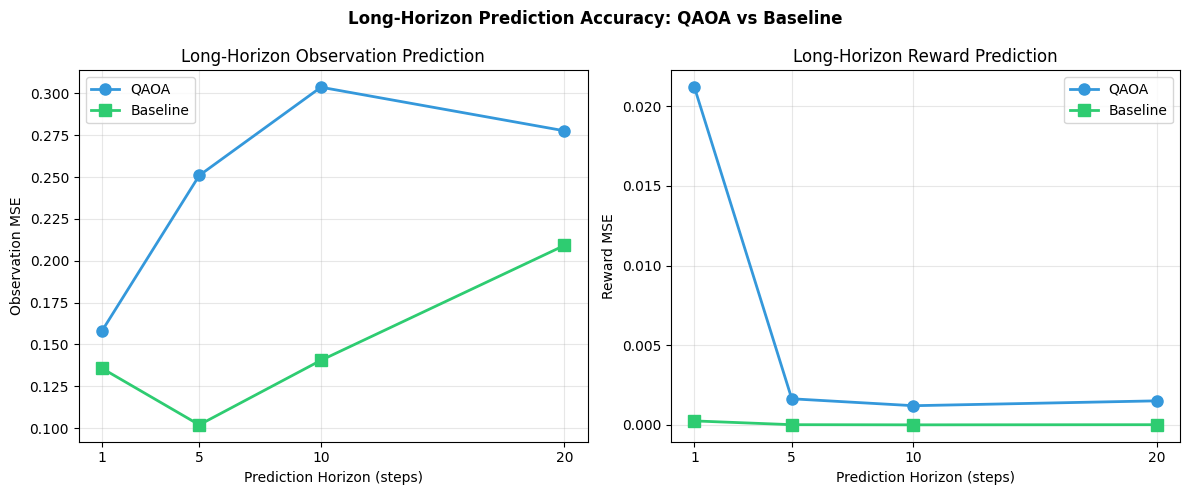


Long-horizon results stored for cross-notebook comparison.


In [18]:
"""
Cell: Long-Horizon Visualization
Purpose: Visualize how prediction error grows with horizon
"""

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

horizons = [1, 5, 10, 20]

# Observation MSE vs Horizon
ax = axes[0]
qaoa_obs = [qaoa_horizon['obs_mse'].get(h, float('nan')) for h in horizons]
baseline_obs = [baseline_horizon['obs_mse'].get(h, float('nan')) for h in horizons]

ax.plot(horizons, qaoa_obs, 'o-', color=COLORS['qaoa'], linewidth=2, 
        markersize=8, label='QAOA')
ax.plot(horizons, baseline_obs, 's-', color=COLORS['baseline'], linewidth=2, 
        markersize=8, label='Baseline')
ax.set_xlabel('Prediction Horizon (steps)')
ax.set_ylabel('Observation MSE')
ax.set_title('Long-Horizon Observation Prediction')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(horizons)

# Reward MSE vs Horizon
ax = axes[1]
qaoa_rew = [qaoa_horizon['reward_mse'].get(h, float('nan')) for h in horizons]
baseline_rew = [baseline_horizon['reward_mse'].get(h, float('nan')) for h in horizons]

ax.plot(horizons, qaoa_rew, 'o-', color=COLORS['qaoa'], linewidth=2, 
        markersize=8, label='QAOA')
ax.plot(horizons, baseline_rew, 's-', color=COLORS['baseline'], linewidth=2, 
        markersize=8, label='Baseline')
ax.set_xlabel('Prediction Horizon (steps)')
ax.set_ylabel('Reward MSE')
ax.set_title('Long-Horizon Reward Prediction')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(horizons)

fig.suptitle('Long-Horizon Prediction Accuracy: QAOA vs Baseline', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Store results for later comparison
long_horizon_results = {
    'qaoa': qaoa_horizon,
    'baseline': baseline_horizon
}
print("\nLong-horizon results stored for cross-notebook comparison.")

---
## 10. Summary

In [19]:
"""
Cell: Save Results
Purpose: Save QAOA model and comparison results
"""

# Save results
results_dir = PROJECT_ROOT / "experiments" / "results" / "qaoa"
results_dir.mkdir(parents=True, exist_ok=True)

# Save model with CORRECT config (matching baseline architecture)
checkpoint = {
    'model_state_dict': qaoa_model.state_dict(),
    'config': {
        # QAOA-specific parameters
        'p_layers': 2,
        'gamma_init': 1.0,
        'beta_init': 0.001,
        'beta_schedule': 'cosine',
        'grad_clip': 1.0,
        # Model architecture (SAME as baseline for fair comparison)
        'obs_dim': 4,
        'action_dim': 2,
        'stoch_dim': 64,            # Matches baseline
        'deter_dim': 512,           # Matches baseline
        'hidden_dim': 512,          # Matches baseline
        'encoder_hidden': [512, 512],
        'decoder_hidden': [512, 512],
        'predictor_hidden': [512, 512],
        # Training config
        'learning_rate': 3e-4,
        'batch_size': 32,
        'seq_len': 20,
        'num_steps': 10000,
        'version': 'fair_comparison_v1'
    },
    'comparison': comparison,
    'final_loss': qaoa_history['total'].iloc[-100:].mean(),
    'final_recon_loss': qaoa_history['recon'].iloc[-100:].mean(),
}
torch.save(checkpoint, results_dir / "cartpole_qaoa.pt")

# Save histories
qaoa_history.to_csv(results_dir / "qaoa_training_history.csv", index=False)
baseline_history.to_csv(results_dir / "baseline_comparison_history.csv", index=False)

print(f"Results saved to: {results_dir}")
print(f"\nSaved config:")
print(f"  Model: stoch={64}, deter={512}, hidden={512}")
print(f"  QAOA: p_layers={2}, beta={0.001}, schedule=cosine")
print(f"  Fair comparison: Both models have ~4.7M parameters")

Results saved to: d:\Git Repos\Quantum-Enhanced-Simulation-Learning-for-Reinforcement-Learning\experiments\results\qaoa

Saved config:
  Model: stoch=64, deter=512, hidden=512
  QAOA: p_layers=2, beta=0.001, schedule=cosine
  Fair comparison: Both models have ~4.7M parameters


In [20]:
"""
Cell: Summary
Purpose: Display phase summary
"""

print("="*60)
print("PHASE 3 COMPLETE: QAOA-ENHANCED TRAINING")
print("="*60)

print("\n[1] Components Implemented")
print("    - CostOperator: Gradient-based updates (analog to U(C,γ))")
print("    - MixingOperator: Exploration perturbations (analog to U(B,β))")
print("    - QAOAOptimizer: Full QAOA-inspired training loop")
print("    - QAOAWorldModelTrainer: Integration with world model")

print("\n[2] QAOA Configuration (FIXED)")
print(f"    - p_layers: 2")
print(f"    - gamma_init: 1.0")
print(f"    - beta_init: 0.001 (reduced for stability)")
print(f"    - beta_schedule: cosine")
print(f"    - Noise applied to: gradients (not parameters)")

print("\n[3] Model Architecture (FAIR COMPARISON)")
print(f"    - stoch_dim: 64")
print(f"    - deter_dim: 512")
print(f"    - hidden_dim: 512")
print(f"    - Parameters: ~4.7M (SAME for both QAOA and Baseline)")

print("\n[4] Comparison Results")
print(f"    - QAOA Final Loss: {comparison['mean_loss_1']:.4f}")
print(f"    - Baseline Final Loss: {comparison['mean_loss_2']:.4f}")
print(f"    - Statistical Significance: p={comparison['p_value']:.4f}")
print(f"    - Effect Size (Cohen's d): {comparison['cohens_d']:.3f}")

winner = "QAOA" if comparison['mean_loss_1'] < comparison['mean_loss_2'] else "Baseline"
print(f"\n[5] Winner: {winner}")

print("\n" + "="*60)
print("NEXT STEPS: Phase 4 - Superposition-Enhanced Experience Replay")
print("="*60)
print("""
In Phase 4, we will:
  1. Implement quantum-inspired weighted experience sampling
  2. Create amplitude-based prioritization
  3. Add interference effects for better sample efficiency
  4. Compare with standard replay buffer
""")

PHASE 3 COMPLETE: QAOA-ENHANCED TRAINING

[1] Components Implemented
    - CostOperator: Gradient-based updates (analog to U(C,γ))
    - MixingOperator: Exploration perturbations (analog to U(B,β))
    - QAOAOptimizer: Full QAOA-inspired training loop
    - QAOAWorldModelTrainer: Integration with world model

[2] QAOA Configuration (FIXED)
    - p_layers: 2
    - gamma_init: 1.0
    - beta_init: 0.001 (reduced for stability)
    - beta_schedule: cosine
    - Noise applied to: gradients (not parameters)

[3] Model Architecture (FAIR COMPARISON)
    - stoch_dim: 64
    - deter_dim: 512
    - hidden_dim: 512
    - Parameters: ~4.7M (SAME for both QAOA and Baseline)

[4] Comparison Results
    - QAOA Final Loss: 1.2564
    - Baseline Final Loss: 1.0031
    - Statistical Significance: p=0.0000
    - Effect Size (Cohen's d): 15.307

[5] Winner: Baseline

NEXT STEPS: Phase 4 - Superposition-Enhanced Experience Replay

In Phase 4, we will:
  1. Implement quantum-inspired weighted experience sa